In [ ]:
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

SEED = 2311
N_SPLITS = 5

In [ ]:
train = pd.read_csv('https://github.com/sidt-ai/MachineHack-hackathons/blob/main/MH_datasets/Shiv_Nadar_DAC/train.csv?raw=true')
test = pd.read_csv('https://github.com/sidt-ai/MachineHack-hackathons/blob/main/MH_datasets/Shiv_Nadar_DAC/test.csv?raw=true')
submission = pd.read_csv('https://raw.githubusercontent.com/sidt-ai/MachineHack-hackathons/main/MH_datasets/Shiv_Nadar_DAC/submission.csv')

In [ ]:
train.head(3)

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268


In [ ]:
test.head(3)

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type
0,DRM23,10.156725,Snack Foods,119.319482,OUT013,1999,High,Tier 3
1,FDG47,10.434425,Household,263.600449,OUT018,1987,High,Tier 3
2,FDN21,11.953589,Health and Hygiene,246.286990,OUT018,1997,High,Tier 1


In [ ]:
train.shape, test.shape

((87864, 9), (37656, 8))

# Folds for cross-validation

In [ ]:
train['fold'] = -1

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(kf.split(X=train)):
    train.loc[val_idx, 'fold'] = fold

In [ ]:
train.head(3)

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales,fold
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781,4
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375,1
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268,1


# Data Exploration

In [ ]:
train.dtypes

Item_ID                  object
Item_W                  float64
Item_Type                object
Item_MRP                float64
Outlet_ID                object
Outlet_Year               int64
Outlet_Size              object
Outlet_Location_Type     object
Sales                   float64
fold                      int64
dtype: object

In [ ]:
#Item_Type - Item type

train.Item_Type.value_counts()

Baking Goods             14666
Fruits and Vegetables    14328
Meat                      8099
Snack Foods               7817
Household                 6018
Soft Drinks               5396
Frozen Foods              5129
Canned                    4565
Dairy                     3807
Others                    3688
Breads                    3509
Hard Drinks               3129
Health and Hygiene        2995
Starchy Foods             2974
Seafood                   1107
Breakfast                  637
Name: Item_Type, dtype: int64

In [ ]:
test.Item_Type.value_counts()

Snack Foods              6862
Household                4809
Fruits and Vegetables    4447
Frozen Foods             4361
Dairy                    3489
Canned                   3413
Health and Hygiene       2273
Soft Drinks              2178
Baking Goods             1769
Meat                     1313
Hard Drinks               592
Breakfast                 554
Others                    545
Breads                    457
Starchy Foods             427
Seafood                   167
Name: Item_Type, dtype: int64

In [ ]:
set(train.Item_Type.values) - set(test.Item_Type.values)

set()

No extra item-types in test set.

In [ ]:
#Outlet_ID

train.Outlet_ID.nunique(), test.Outlet_ID.nunique()

(5, 5)

In [ ]:
set(train.Outlet_ID.values) - set(test.Outlet_ID.values)

set()

No new outlets in test set.

In [ ]:
#Outlet_Size

train.Outlet_Size.value_counts()

Small     48614
Medium    26683
High      12567
Name: Outlet_Size, dtype: int64

In [ ]:
test.Outlet_Size.value_counts()

Medium    15236
Small     13504
High       8916
Name: Outlet_Size, dtype: int64

In [ ]:
#Outlet_Location_Type

train.Outlet_Location_Type.value_counts()

Tier 1    33567
Tier 3    29044
Tier 2    25253
Name: Outlet_Location_Type, dtype: int64

In [ ]:
test.Outlet_Location_Type.value_counts()

Tier 3    15732
Tier 1    12830
Tier 2     9094
Name: Outlet_Location_Type, dtype: int64

In [ ]:
#Outlet_Year

train.Outlet_Year.describe()

count    87864.00000
mean      1999.87063
std          6.63429
min       1987.00000
25%       1997.00000
50%       1999.00000
75%       2004.00000
max       2009.00000
Name: Outlet_Year, dtype: float64

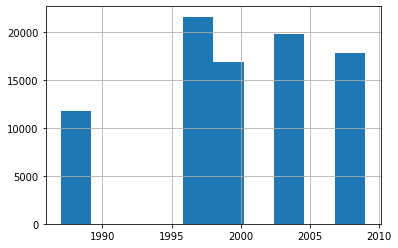

In [ ]:
train.Outlet_Year.hist()

In [ ]:
test.Outlet_Year.describe()

count    37656.000000
mean      2000.032956
std          6.882847
min       1987.000000
25%       1997.000000
50%       1999.000000
75%       2004.000000
max       2009.000000
Name: Outlet_Year, dtype: float64

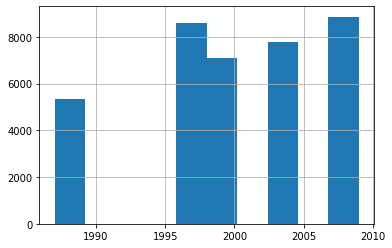

In [ ]:
test.Outlet_Year.hist()

Almost similar distributions of Outlet Establishment Year for train and test data

In [ ]:
#Item_ID

train.Item_ID.nunique()

895

Only 895 unique items. 

In [ ]:
train.loc[train.Item_ID == 'FDU32'].head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales,fold
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781,4
201,FDU32,21.204921,Baking Goods,144.538849,OUT046,1997,Small,Tier 2,774.493535,1
658,FDU32,21.115653,Baking Goods,116.327204,OUT013,2004,Small,Tier 1,1319.579290,0
1328,FDU32,19.429515,Hard Drinks,200.721601,OUT035,2004,Small,Tier 1,1395.479908,1
1480,FDU32,19.632053,Meat,161.730619,OUT046,1999,Small,Tier 1,1110.402053,0


In [ ]:
train.groupby(['Item_ID', 'Outlet_ID']).get_group(('FDU32', 'OUT046')).head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales,fold
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781,4
201,FDU32,21.204921,Baking Goods,144.538849,OUT046,1997,Small,Tier 2,774.493535,1
1480,FDU32,19.632053,Meat,161.730619,OUT046,1999,Small,Tier 1,1110.402053,0
2664,FDU32,21.116959,Fruits and Vegetables,198.656524,OUT046,2009,Small,Tier 3,5513.441968,1
5065,FDU32,19.418751,Baking Goods,193.897638,OUT046,2004,High,Tier 1,2878.893714,4


In [ ]:
train.groupby(['Item_ID', 'Outlet_ID']).get_group(('NCT54', 'OUT035')).head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales,fold
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375,1
1886,NCT54,20.178095,Baking Goods,120.860176,OUT035,1997,Small,Tier 1,228.109961,0
2794,NCT54,20.922726,Fruits and Vegetables,184.728315,OUT035,1997,Small,Tier 1,2366.254938,3
6254,NCT54,19.812663,Fruits and Vegetables,190.911728,OUT035,1997,Small,Tier 1,1799.726945,4
7831,NCT54,20.723483,Breads,48.826464,OUT035,1997,Medium,Tier 3,1471.376822,1


Different values of features for same (Item_ID, Outlet_ID) pair. Looks like a data-integrity issue.

# Data Modeling

In [ ]:
!pip install --quiet catboost

In [ ]:
features = ['Item_ID', 'Item_W', 'Item_Type', 'Item_MRP', 'Outlet_ID', 'Outlet_Year', 'Outlet_Size', 'Outlet_Location_Type']
cat_features = ['Item_ID', 'Item_Type', 'Outlet_ID', 'Outlet_Year', 'Outlet_Size', 'Outlet_Location_Type']

In [ ]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.03,
    loss_function='RMSE',
    task_type='GPU',
    random_seed=SEED
)

In [ ]:
def custom_cross_val_predict(train, test, features, cat_features, model):
    oof_preds = {}
    test_preds = []
    scores = []
    
    cv_start = time.time()
    
    for fold in range(N_SPLITS):
        print('-' * 40)
        
        xtrain = train[train.fold != fold].reset_index(drop=True)

        xval = train[train.fold == fold].reset_index(drop=True)    
        val_idx = xval.index.tolist()
        
        fold_start = time.time()
        
        model.fit(
            xtrain[features], xtrain.Sales,
            cat_features=cat_features,
            eval_set=[(xval[features], xval.Sales)],
            early_stopping_rounds=100,
            verbose=100,
            plot=True
        )
        val_preds = model.predict(xval[features]) #out-of-fold predictions      
        oof_preds.update(dict(zip(val_idx, val_preds)))
        rmse = mean_squared_error(xval.Sales, val_preds, squared=False)
        scores.append(rmse)
        
        fold_end = time.time()
        
        print(f'Fold #{fold}: RMSE = {rmse:.5f}\t[Time: {fold_end - fold_start:.2f} secs]')
        
        test_preds.append(model.predict(test[features])) #test predictions
        
    cv_end = time.time()
    print(f'Average RMSE = {np.mean(scores):.5f} with std. dev. = {np.std(scores):.5f}')
    print(f'[Total time: {cv_end - cv_start:.2f} secs]')
    
    oof_preds = pd.DataFrame.from_dict(oof_preds, orient='index').reset_index()
    test_preds = np.mean(np.column_stack(test_preds), axis=1)
    
    return oof_preds, test_preds

In [ ]:
submission1 = submission.copy()
oof_preds, submission1.Sales = custom_cross_val_predict(train, test, 
                                                       features, cat_features, 
                                                       model)

In [ ]:
submission1.to_csv('submission1.csv', index=False)

!head submission1.csv

# Submission 2

In [ ]:
fold = 3
xtrain = train[train.fold != fold].reset_index(drop=True)
xval = train[train.fold == fold].reset_index(drop=True)
        
fold_start = time.time()

model2 = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.03,
    loss_function='RMSE',
    task_type='GPU',
    random_seed=SEED
)

model2.fit(
  xtrain[features], xtrain.Sales,
  cat_features=cat_features,
  eval_set=[(xval[features], xval.Sales)],
  early_stopping_rounds=100,
  verbose=100,
  plot=True
)

val_preds2 = model2.predict(xval[features]) #out-of-fold predictions      
rmse = mean_squared_error(xval.Sales, val_preds2, squared=False)
        
fold_end = time.time()
        
print(f'RMSE = {rmse:.5f}\t[Time: {fold_end - fold_start:.2f} secs]')

In [ ]:
submission2 = submission.copy()
submission2.Sales = model2.predict(test[features]) #test predictions

submission2.to_csv('submission2.csv', index=False)

!head submission2.csv